# Use emcee to sample Lya posterior as a function of mean flux

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import lya_theory
import likelihood

## Setup Lya likelihood function

In [2]:
# read P1D measurement
data=data_PD2013.P1D_PD2013(blind_data=True)
zs=data.z
Nz=len(zs)

In [3]:
undersample_z=2
use_gp=True
if use_gp:
    emu=gp_emulator.GPEmulator(undersample_z=undersample_z,verbose=True,paramList=None,kmax_Mpc=5,train=True)
else:
    emu=linear_emulator.LinearEmulator(undersample_z=undersample_z,verbose=True)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.972, 0.42000000000000004, -2.315, -0.19, 0.7250000000000001, 1.3250000000000002], '1': [0.96, 0.28, -2.295, -0.2, 1.3250000000000002, 1.475], '2': [0.966, 0.3, -2.305, -0.26, 1.025, 0.875], '3': [0.956, 0.4, -2.275, -0.25, 0.575, 1.175], '4': [0.968, 0.44, -2.325, -0.22, 1.475, 0.7250000000000001], '5': [

Arxiv setup, containing 2700 entries
will train GP emulator
Rescaled params to unity volume
Training GP
Optimised


In [4]:
# setup theory to predict Lya 1D power
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=True)

Note: redshifts have been re-sorted (earliest first)


In [5]:
like=likelihood.Likelihood(data=data,theory=theory,verbose=True)

got parameters
g_star = 0.9677508579459803
f_star = 0.9813695578403229
Delta2_star = 0.3601759052864235
n_star = -2.299335667257512
alpha_star = -0.2165270371206627
ln_tau_0 = -0.7945801724139945
ln_tau_1 = 3.18
ln_T0_0 = 9.210340371976184
ln_T0_1 = 0.0
ln_gamma_0 = 0.3364722366212129
ln_gamma_1 = 0.0
ln_kF_0 = -1.7037485919053417
ln_kF_1 = 0
likelihood setup with 1 free parameters
1 free parameters


In [6]:
for p in like.free_params:
    print(p.name,p.value)

ln_tau_0 -0.7945801724139945


In [7]:
# test likelihood function
values=[0.5]
like.log_prob(values=values)

0 2.2 model {'Delta2_p': 0.5565113014577152, 'n_p': -2.2994794185069685, 'alpha_p': -0.21637589659959175, 'f_p': 0.9652245245021047, 'mF': 0.868562902154964, 'gamma': 1.4, 'sigT_Mpc': 0.1306960092605284, 'kF_Mpc': 12.672154332566837}
1 2.4 model {'Delta2_p': 0.49488568402750766, 'n_p': -2.299479501501992, 'alpha_p': -0.216376717675827, 'f_p': 0.970653664795261, 'mF': 0.8429250908025321, 'gamma': 1.4, 'sigT_Mpc': 0.127446927252886, 'kF_Mpc': 12.995213267980114}
2 2.6 model {'Delta2_p': 0.44280074273630654, 'n_p': -2.2994793009304813, 'alpha_p': -0.2163757813099382, 'f_p': 0.9749969128512308, 'mF': 0.8146976015761065, 'gamma': 1.4, 'sigT_Mpc': 0.12436389094838281, 'kF_Mpc': 13.317370398835509}
3 2.8 model {'Delta2_p': 0.3984192005063586, 'n_p': -2.299479372599087, 'alpha_p': -0.21637637290776252, 'f_p': 0.9785045052118703, 'mF': 0.7839699992129093, 'gamma': 1.4, 'sigT_Mpc': 0.12144623367196278, 'kF_Mpc': 13.637310519431555}
4 3.0 model {'Delta2_p': 0.3603165013768066, 'n_p': -2.299479459

-10526.307755009784

In [8]:
#cProfile.run("like.log_prob(values=values,linP_Mpc_params=linP_Mpc_params)",sort='cumtime')

### Setup function to be called in MCMC

In [9]:
def log_prob(values,like,verbose=False):
    test_log_prob=like.log_prob(values=values)
    if np.isnan(test_log_prob):
        if verbose:
            print('parameter values outside hull',values)
        return -np.inf
    return test_log_prob

In [10]:
like.go_silent()

In [11]:
np.exp(-np.exp(-2.0))

0.8734230184931167

In [12]:
xs=np.linspace(0.0,1.0,100)
xmin=like.free_params[0].min_value
xmax=like.free_params[0].max_value
print(xmin,'< ln_tau_0 <',xmax)
print(np.exp(xmin),'< tau_0 <',np.exp(xmax))
print(np.exp(-np.exp(xmax)),'< <F> <',np.exp(-np.exp(xmin)))
mf=np.exp(-np.exp(xmin+xs*(xmax-xmin)))
lnps=[log_prob([x],like) for x in xs]

-2.0 < ln_tau_0 < -0.5
0.1353352832366127 < tau_0 < 0.6065306597126334
0.545239211892605 < <F> < 0.8734230184931167


Text(0, 0.5, '$\\chi^2$')

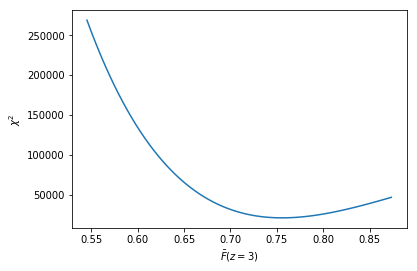

In [13]:
plt.plot(mf,-2.0*np.array(lnps))
plt.xlabel(r'$\bar F(z=3)$')
plt.ylabel(r'$\chi^2$')

### Setup MCMC

In [14]:
# for now we'll have only one dimension (mean flux)
ndim=1
# setup initial walkers
nwalkers = 10
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

In [15]:
p0.flatten()

array([0.73214041, 0.68254957, 0.54973855, 0.09911585, 0.57698111,
       0.73573835, 0.56844149, 0.31076509, 0.89199675, 0.40741594])

In [16]:
# test function
log_prob(p0[0],like)

-25540.484291371482

In [17]:
# setup sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[like])

In [18]:
# burn-in phase
pos, prob, state = sampler.run_mcmc(p0, 50)
print('finished burn-in at',pos.flatten(),prob)

finished burn-in at [0.48132328 0.48304965 0.4841928  0.48421378 0.48470597 0.48469542
 0.48658526 0.48551111 0.48715319 0.48650704] [-10495.96996759 -10494.50863768 -10494.00489445 -10494.00120748
 -10493.90343388 -10493.90478687 -10494.1575941  -10493.88804397
 -10494.43771448 -10494.12768415]


In [19]:
# reset and run actual chains
sampler.reset()
nsteps=200
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if i % 20 == 0:
        print(i,result[0].flatten())

0 [0.48132328 0.48304965 0.4841928  0.48395347 0.48332787 0.48468052
 0.48547291 0.48513793 0.48648699 0.48734707]
20 [0.48219504 0.48332124 0.48589518 0.48358653 0.48305895 0.48460424
 0.4838663  0.48443274 0.48492316 0.4830521 ]
40 [0.48612081 0.48621909 0.48476522 0.48523219 0.48735694 0.48504702
 0.48273755 0.48421412 0.48750953 0.48222447]
60 [0.48705184 0.48565643 0.48508514 0.48917921 0.48119104 0.48092606
 0.48198492 0.48722501 0.48365087 0.48364999]
80 [0.4860817  0.48635868 0.48476353 0.48718548 0.48636267 0.48416125
 0.48539967 0.48814395 0.48255531 0.48857893]
100 [0.48561118 0.48673878 0.48721284 0.48523426 0.48730863 0.48417977
 0.48432707 0.48791434 0.48562027 0.48949379]
120 [0.4814087  0.48524186 0.48518266 0.48251303 0.49125196 0.48651865
 0.48604906 0.48773063 0.48215459 0.48431736]
140 [0.48764422 0.48432127 0.48429777 0.48301968 0.48821029 0.48943254
 0.48376084 0.484836   0.48699647 0.48268704]
160 [0.48879227 0.48587566 0.48471776 0.48458526 0.48782678 0.4845754


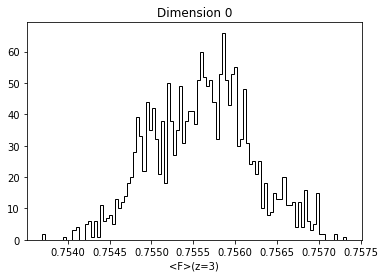

In [20]:
for i in range(ndim):
    plt.figure()
    mf=np.exp(-np.exp(xmin+sampler.flatchain[:,i]*(xmax-xmin)))
    plt.hist(mf, 100, color="k", histtype="step")
    plt.xlabel('<F>(z=3)')
    plt.title("Dimension {0:d}".format(i))

In [21]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.814


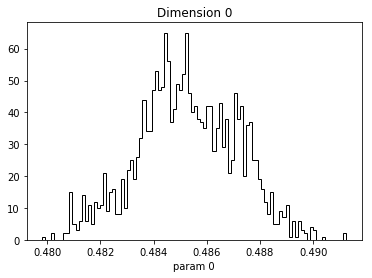

In [22]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.xlabel('param 0')
    plt.title("Dimension {0:d}".format(i))